<a href="https://colab.research.google.com/github/cs16677/ce888/blob/master/lab4/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

data = pd.read_csv("bank-additional-full.csv", delimiter=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
def rem_unknown(data, col):
  return data[~data[col].isin(["unknown"])]

def rem_unknowns(data, cols):
  for col in cols:
    data = rem_unknown(data, col)
  return data

def apply_encoder(data, cols):
  encoder = LabelEncoder()
  for col in cols: 
    data[[col]] = data[[col]].apply(encoder.fit_transform)
  return data

# remove rows with "unknown" columns
columns = np.array(["job", "marital", "education", "default", "housing", "loan"])
filt_data = rem_unknowns(data, columns)
# delete duration
del filt_data["duration"]

# remove y_no
filt_data = pd.get_dummies(filt_data, columns=["y"])
del filt_data["y_no"] 

# use label encoding on all string columns
columns = np.append(columns, ["contact", "month", "day_of_week", "poutcome"])
filt_data = apply_encoder(filt_data, columns)

print(data.size)
print(filt_data.size)
filt_data[160:170]

864948
609760


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y_yes
284,42,1,0,2,0,1,0,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
285,44,1,0,1,0,0,0,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
286,39,3,1,2,0,1,0,1,6,1,3,999,0,1,1.1,93.994,-36.4,4.857,5191.0,1
287,37,0,2,3,0,1,1,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
289,36,7,1,3,0,0,0,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
290,42,4,0,6,0,1,0,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
291,31,0,1,3,0,1,1,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
293,45,1,1,0,0,1,0,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
294,37,9,2,5,0,1,0,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
295,47,6,1,5,0,0,0,1,6,1,2,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


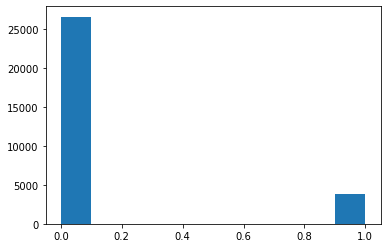

In [0]:
plt.hist(filt_data["y_yes"])

In [0]:
x_df = filt_data.copy()
del x_df["y_yes"]
y_df = filt_data["y_yes"].copy()
y = y_df.values.T[0]

In [0]:
classifier = ExtraTreesClassifier(n_estimators=100)
fold = StratifiedKFold(n_splits=10)
confusion = np.array([[0, 0], [0, 0]])
for train_i, test_i in fold.split(x_df, y_df):
  y_train = y_df.iloc[train_i].values
  x_train = x_df.iloc[train_i]

  y_test = y_df.iloc[test_i].values
  x_test = x_df.iloc[test_i]

  classifier.fit(x_train, y_train)
  predictions = classifier.predict(x_test)
  confusion += confusion_matrix(y_test, predictions)

print('Total:', len(filt_data))
print('Confusion matrix:')
print(confusion)

Total: 30488
Confusion matrix:
[[12197 14432]
 [ 3440   419]]


[ 0 17 18 10 14  1 16  3 15 11  9  2  8  5 13  6  7 12  4]
Feature ranking:
1. age (0.148004)
2. euribor3m (0.135106)
3. nr.employed (0.117390)
4. campaign (0.084618)
5. emp.var.rate (0.080928)
6. job (0.064834)
7. cons.conf.idx (0.059284)
8. education (0.052941)
9. cons.price.idx (0.047915)
10. pdays (0.043305)
11. day_of_week (0.041717)
12. marital (0.028192)
13. month (0.026206)
14. housing (0.020151)
15. poutcome (0.019599)
16. loan (0.014568)
17. contact (0.008127)
18. previous (0.007113)
19. default (0.000001)


(0, 0.2426050340908997)

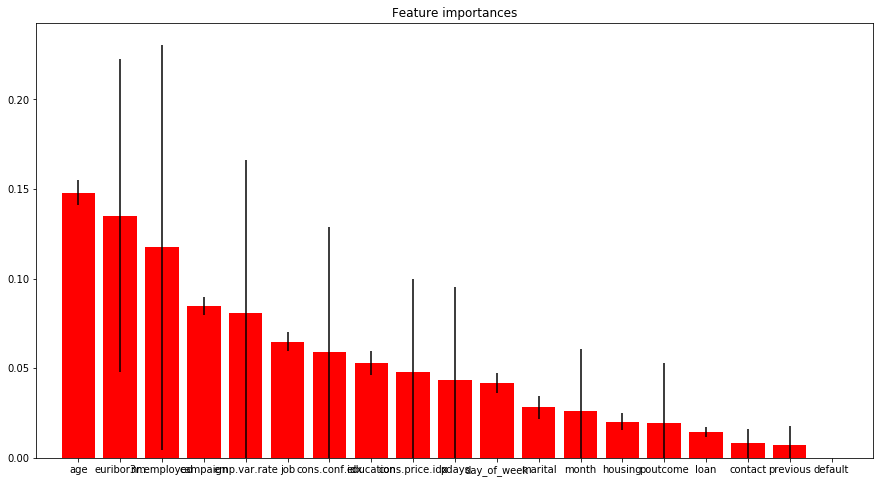

In [0]:
features = list(filt_data)
X = x_df
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices])
plt.xlim([-1, X.shape[1]])
fig.set_size_inches(15,8)
axes = plt.gca()
axes.set_ylim([0,None])
